In [1]:
import numpy as np
import cvxpy as cp

Data columns:  ['cases', 'hospitalizations', 'deaths']
Max Daily Deaths:  4475.0


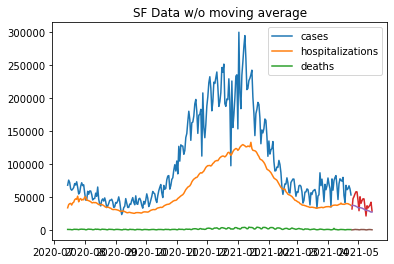

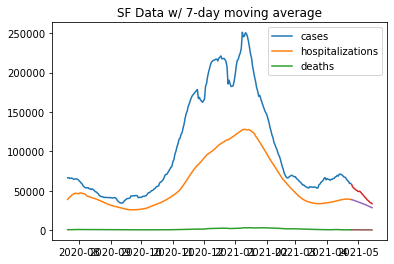

In [43]:
import sys, os
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from src import utils

# load data from processed csv
path_loc = '../datasets/processed/united_states.csv'
data, dates, columns = utils.read_csv(path_loc)
print("Data columns: ", columns)
print("Max Daily Deaths: ", data[:,2].max())

# without averaging

train, test, train_dates, test_dates = utils.train_test_split(data, dates, days=42)

plt.figure()
plt.title('SF Data w/o moving average')
plt.plot(train_dates, train)
plt.plot(test_dates, test)
plt.legend(columns)
plt.show()

# with 7-day moving average
mva_data, mva_dates = utils.moving_average(data, dates, days=7)
train, test, train_dates, test_dates = utils.train_test_split(mva_data, mva_dates)

plt.figure()
plt.title('SF Data w/ 7-day moving average')
plt.plot(train_dates, train)
plt.plot(test_dates, test)
plt.legend(columns)
plt.show()


In [44]:
print(columns)
print(train.shape)
print(train[100])

['cases', 'hospitalizations', 'deaths']
(278, 3)
[77360.         41430.57142857   846.42857143]


usage: ipykernel_launcher.py [-h] --country COUNTRY [COUNTRY ...]
ipykernel_launcher.py: error: the following arguments are required: --country


SystemExit: 2

/Users/agraur/anaconda3/envs/covid/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [13]:
def estimate_params2(V, U):
    if len(V) != len(U):
        raise ValueError("Arrays must have the same size")
    T = len(V)
    #gammas = np.ones((2, 2))
    gammas = cp.Variable(2)
    constraints = [gammas >= 0.01]
    expression = 0
    for d in range(T-1):
        #expression += cp.sum_squares(np.array([V[d+1], U[d+1]]) - gammas @ np.array([V[d], U[d]]))
        expression += cp.square(V[d+1] - (U[d] + V[d]) * gammas[0])
        expression += cp.square(U[d+1] - (U[d] + V[d]) * gammas[1])
    problem = cp.Problem(cp.Minimize(expression), constraints)
    problem.solve(solver = cp.ECOS)
    
    opt_val = gammas.value
    
    return opt_val

In [14]:
def estimate_params4(V, U):
    if len(V) != len(U):
        raise ValueError("Arrays must have the same size")
    T = len(V)
    #gammas = np.ones((2, 2))
    gammas = cp.Variable((2, 2))
    constraints = [gammas >= 0.01]
    expression = 0
    for d in range(T-1):
        expression += cp.sum_squares(np.array([V[d+1], U[d+1]]) - gammas @ np.array([V[d], U[d]]))
    problem = cp.Problem(cp.Minimize(expression), constraints)
    problem.solve(solver = cp.ECOS)
    
    opt_val = gammas.value
    
    return opt_val

In [15]:
def l1_estimate_params4(V, U, lbd):
    if len(V) != len(U):
        raise ValueError("Arrays must have the same size")
    T = len(V)
    
    gammas = cp.Variable((T, 4))
    constraints = [gammas >= 0.01]
    expression = 0
    for d in range(T-1):
        expression += cp.square(V[d+1] - gammas[d, 0] * V[d] - gammas[d, 1] * U[d])
        expression += cp.square(U[d+1] - gammas[d, 2] * V[d] - gammas[d, 3] * U[d])
        expression += lbd * cp.norm(gammas[d] - gammas[d+1], 1)
    
    problem = cp.Problem(cp.Minimize(expression), constraints)
    problem.solve(solver = cp.ECOS_BB, verbose = True)
    
    opt_val = gammas.value
    
    return opt_val

In [27]:
def l1_estimate_params2(V, U, lbd):
    if len(V) != len(U):
        raise ValueError("Arrays must have the same size")
    T = len(V)
    
    gammas = cp.Variable((T, 2))
    constraints = [gammas >= 0.01]
    expression = 0
    for d in range(T-1):
        expression += cp.square(V[d+1] - gammas[d, 0] * (U[d] + V[d]))
        expression += cp.square(U[d+1] - gammas[d, 1] * (U[d] + V[d]))
        expression += lbd * cp.norm(gammas[d] - gammas[d+1], 1)
    
    problem = cp.Problem(cp.Minimize(expression), constraints)
    problem.solve()
    
    opt_val = gammas.value
    
    return opt_val

In [17]:
def delta_estimate_params4(delta, V, U):
    if len(V) != len(U):
        raise ValueError("Arrays must have the same size")
    T = len(V)
    gammas = cp.Variable((T, 4))
    constraints = [gammas >= 0.001]
    for d in range(T-1):
        constraints += [cp.norm(gammas[d+1,:]-gammas[d,:],'inf') <= delta]
    expression = 0
    for d in range(T-1):
        expression += cp.square(V[d+1] - gammas[d, 0] * V[d] - gammas[d, 1] * U[d])
        expression += cp.square(U[d+1] - gammas[d, 2] * V[d] - gammas[d, 3] * U[d])
        #expression += cp.sum_squares(np.array([V[d+1], U[d+1]]) - gammas[d,:] @ np.array([V[d], U[d]]))
    problem = cp.Problem(cp.Minimize(expression), constraints)
    problem.solve(solver = cp.ECOS, max_iters = 10000)

    opt_val = gammas.value
  
    return opt_val

In [18]:
def delta_estimate_params2(delta, V, U):
    if len(V) != len(U):
        raise ValueError("Arrays must have the same size")
    T = len(V)
    gammas = cp.Variable((T, 2))
    constraints = [gammas >= 0.001]
    for d in range(T-1):
        constraints += [cp.norm(gammas[d+1,:]-gammas[d,:],'inf') <= delta]
    expression = 0
    for d in range(T-1):
        expression += cp.square(V[d+1] - gammas[d, 0] * (V[d] + U[d]))
        expression += cp.square(U[d+1] - gammas[d, 1] * (V[d] + U[d]))
        #expression += cp.sum_squares(np.array([V[d+1], U[d+1]]) - gammas[d,:] @ np.array([V[d], U[d]]))
    problem = cp.Problem(cp.Minimize(expression), constraints)
    problem.solve(solver = cp.ECOS, max_iters = 10000)

    opt_val = gammas.value
  
    return opt_val

In [79]:
true_gammas = np.array([0.15, 1.05])
true_gammas

array([0.15, 1.05])

In [83]:
T = 25
U = np.zeros(T)
V = np.zeros(T)
V[0] = 2
U[0] = 5
'''
for i in range(T-1):
    sigma = 0.001
    I = U[i] + V[i]
    noise1 = np.random.normal(0, sigma * np.sqrt(V[i]))
    noise2 = np.random.normal(0, sigma * np.sqrt(U[i]))
    V[i+1] = V[i] * true_gammas[0, 0] + U[i] * true_gammas[0, 1] + noise1
    U[i+1] = V[i] * true_gammas[1, 0] + U[i] * true_gammas[1, 1] + noise2
'''
for i in range(T-1):
    sigma = 1
    I = U[i] + V[i]
    noise1 = max(0, np.random.normal(0, sigma * np.sqrt(I)))
    noise2 = max(0, np.random.normal(0, sigma * np.sqrt(I)))
    V[i+1] = I * true_gammas[0] + noise1
    U[i+1] = I * true_gammas[1] + noise2


In [90]:
lbd = 100
gammaest = l1_estimate_params2(V, U, lbd)
gammaest

array([[0.21199293, 1.07465505],
       [0.21199293, 1.07465505],
       [0.21199293, 1.07465505],
       [0.21199293, 1.07465505],
       [0.21199293, 1.07465505],
       [0.23436272, 1.07465505],
       [0.24419071, 1.07465505],
       [0.17759417, 1.11722458],
       [0.16570143, 1.24391683],
       [0.20043764, 1.05790198],
       [0.15499048, 1.1688114 ],
       [0.15503571, 1.20882486],
       [0.15019412, 1.05152964],
       [0.15019412, 1.07653736],
       [0.15019412, 1.0792476 ],
       [0.15019412, 1.1027316 ],
       [0.1995738 , 1.05029754],
       [0.15019046, 1.09083338],
       [0.17269328, 1.05607521],
       [0.15008189, 1.05008189],
       [0.17476273, 1.08629526],
       [0.16141843, 1.05003575],
       [0.16857876, 1.06357255],
       [0.15000802, 1.07485545],
       [0.15000802, 1.07485545]])

Dynamic gammas generation

In [92]:
dynamic_gammas = np.empty((T, 2))

dynamic_gammas[0, 0] = 0.15
dynamic_gammas[0, 1] = 1.05

for t in range(T - 1):
    dynamic_gammas[t+1, 0] =dynamic_gammas[t, 0] + 0.005
    dynamic_gammas[t+1, 1] =dynamic_gammas[t, 1] + 0.002

In [93]:
U = np.zeros(T)
V = np.zeros(T)
V[0] = 2
U[0] = 5

for i in range(T-1):
    sigma = 0.1
    I = U[i] + V[i]
    noise1 = max(0, np.random.normal(0, sigma * np.sqrt(I)))
    noise2 = max(0, np.random.normal(0, sigma * np.sqrt(I)))
    V[i+1] = I * dynamic_gammas[i, 0] + noise1
    U[i+1] = I * dynamic_gammas[i, 1] + noise2

In [98]:
lbd = 100
gammaest = l1_estimate_params2(V, U, lbd)
gammaest

array([[0.19800241, 1.07446938],
       [0.19800241, 1.07446938],
       [0.19800241, 1.07446938],
       [0.19800241, 1.07446938],
       [0.19800241, 1.07446938],
       [0.19800241, 1.07446938],
       [0.19800241, 1.07446938],
       [0.19800241, 1.07446938],
       [0.19800241, 1.07446938],
       [0.19800241, 1.07446938],
       [0.19999999, 1.07446938],
       [0.205     , 1.07717808],
       [0.21      , 1.07717808],
       [0.2176883 , 1.07717808],
       [0.22007794, 1.07799999],
       [0.225     , 1.08383233],
       [0.23      , 1.08383233],
       [0.23914577, 1.08671663],
       [0.24      , 1.08637153],
       [0.24929108, 1.09332503],
       [0.25      , 1.09469438],
       [0.25847878, 1.09213235],
       [0.26      , 1.094     ],
       [0.26499031, 1.09649985],
       [0.26499031, 1.09649985]])

In [95]:
dynamic_gammas

array([[0.15 , 1.05 ],
       [0.155, 1.052],
       [0.16 , 1.054],
       [0.165, 1.056],
       [0.17 , 1.058],
       [0.175, 1.06 ],
       [0.18 , 1.062],
       [0.185, 1.064],
       [0.19 , 1.066],
       [0.195, 1.068],
       [0.2  , 1.07 ],
       [0.205, 1.072],
       [0.21 , 1.074],
       [0.215, 1.076],
       [0.22 , 1.078],
       [0.225, 1.08 ],
       [0.23 , 1.082],
       [0.235, 1.084],
       [0.24 , 1.086],
       [0.245, 1.088],
       [0.25 , 1.09 ],
       [0.255, 1.092],
       [0.26 , 1.094],
       [0.265, 1.096],
       [0.27 , 1.098]])

In [99]:
dynamic_gammas = np.empty((T, 2))

dynamic_gammas[0, 0] = 0.15
dynamic_gammas[0, 1] = 1.05

for t in range(T - 1):
    if t % 10 == 0:
        dynamic_gammas[t+1, 0] =dynamic_gammas[t, 0] + 0.15
        dynamic_gammas[t+1, 1] =dynamic_gammas[t, 1] + 0.10
    else:
        dynamic_gammas[t+1, 0] =dynamic_gammas[t, 0] 
        dynamic_gammas[t+1, 1] =dynamic_gammas[t, 1] 
dynamic_gammas

array([[0.15, 1.05],
       [0.3 , 1.15],
       [0.3 , 1.15],
       [0.3 , 1.15],
       [0.3 , 1.15],
       [0.3 , 1.15],
       [0.3 , 1.15],
       [0.3 , 1.15],
       [0.3 , 1.15],
       [0.3 , 1.15],
       [0.3 , 1.15],
       [0.45, 1.25],
       [0.45, 1.25],
       [0.45, 1.25],
       [0.45, 1.25],
       [0.45, 1.25],
       [0.45, 1.25],
       [0.45, 1.25],
       [0.45, 1.25],
       [0.45, 1.25],
       [0.45, 1.25],
       [0.6 , 1.35],
       [0.6 , 1.35],
       [0.6 , 1.35],
       [0.6 , 1.35]])

In [100]:
U = np.zeros(T)
V = np.zeros(T)
V[0] = 2
U[0] = 5

for i in range(T-1):
    sigma = 0.1
    I = U[i] + V[i]
    noise1 = max(0, np.random.normal(0, sigma * np.sqrt(I)))
    noise2 = max(0, np.random.normal(0, sigma * np.sqrt(I)))
    V[i+1] = I * dynamic_gammas[i, 0] + noise1
    U[i+1] = I * dynamic_gammas[i, 1] + noise2

lbd = 100
gammaest = l1_estimate_params2(V, U, lbd)
gammaest

array([[0.30955724, 1.15773154],
       [0.30955724, 1.15773154],
       [0.30955724, 1.15773154],
       [0.30955724, 1.15773154],
       [0.30955724, 1.15773154],
       [0.30955724, 1.15773154],
       [0.30955724, 1.15773154],
       [0.30955724, 1.15094742],
       [0.30955724, 1.15094742],
       [0.30098132, 1.15094742],
       [0.30098132, 1.15094742],
       [0.45171703, 1.25      ],
       [0.45000649, 1.25264383],
       [0.45000649, 1.25008192],
       [0.4500065 , 1.25284816],
       [0.45000649, 1.25004643],
       [0.45003434, 1.25000048],
       [0.45127936, 1.25000034],
       [0.45092367, 1.25000023],
       [0.45002719, 1.25004658],
       [0.45000005, 1.25000005],
       [0.60009693, 1.3502385 ],
       [0.60001063, 1.35      ],
       [0.60002381, 1.35      ],
       [0.60002381, 1.35      ]])

In [59]:
T = 25
#delta = 0.05
lbd = 200
delta1 = 11
delta2 = 18
p = 0.018
V = np.zeros(len(train))
U = np.zeros(len(train))
pred_gammas = np.empty((len(train), 2))

for t in range(70, len(train)):
    U[t - delta2] = U[t - delta2 - 1] + train[t, 2] / p - V[t - delta2] - train[t - delta2, 2] / p + V[t - delta2 * 2]
    V[t - delta1] = V[t - delta1 - 1] + train[t, 1] - train[t - delta1, 1]
    u = U[t - T - delta2:t - delta2]
    v = V[t - T - delta2:t - delta2]
    #gm = estimate_params2(v, u)
    #print(gm)
    #pred_gammas[t] = gm
    
#print(pred_gammas[50:])

In [34]:
print(pred_gammas[50:])

[[0.01000002 0.82608666]
 [0.01000005 0.85184093]
 [0.01000003 0.83869809]
 [0.30207752 0.54754141]
 [0.55636911 0.30279567]
 [0.77425783 0.07344333]
 [0.91359766 0.01000008]
 [1.04646488 0.01000054]
 [1.04668218 0.01000103]
 [1.0466594  0.01000006]
 [1.11189295 0.01000009]
 [1.17539745 0.01000006]
 [1.23942147 0.01000023]
 [1.35224765 0.01000029]
 [1.45760876 0.01000003]
 [1.58180373 0.01000009]
 [1.69974883 0.01      ]
 [1.78924738 0.01000002]
 [1.87205252 0.01000023]
 [1.94768475 0.01      ]
 [2.01434224 0.01      ]
 [2.51135567 0.01000003]
 [3.22557385 0.00999997]
 [3.69925646 0.01      ]
 [3.86749307 0.0099999 ]
 [4.5123353  0.00999992]
 [5.37045396 0.01000004]
 [5.50798851 0.01000003]
 [5.56602659 0.01      ]
 [5.63704067 0.00999998]
 [5.49050234 0.01      ]
 [5.33332024 0.01000001]
 [5.22215492 0.01      ]
 [4.88828234 0.01      ]
 [4.7325477  0.00999998]
 [4.67338156 0.01000001]
 [4.60985789 0.01      ]
 [4.56235682 0.01      ]
 [4.51488755 0.01      ]
 [4.59937237 0.00999998]


In [60]:
print(U[50:])

[ 0.00000000e+00  0.00000000e+00 -4.60317460e+02 -1.22222222e+03
 -1.89682540e+03 -4.30952381e+03 -1.33253968e+04 -2.01984127e+04
 -2.56666667e+04 -3.02417460e+04 -3.57475238e+04 -3.96868889e+04
 -4.36560794e+04 -4.76770000e+04 -5.32030000e+04 -6.13441111e+04
 -7.09233016e+04 -8.25656349e+04 -9.84344762e+04 -1.17166444e+05
 -1.37046730e+05 -1.59864635e+05 -1.86105317e+05 -2.15294889e+05
 -2.47697254e+05 -2.85239127e+05 -3.28857730e+05 -3.75131444e+05
 -4.26529159e+05 -4.83306937e+05 -5.45243540e+05 -6.12157333e+05
 -6.83453127e+05 -7.57570349e+05 -8.37066984e+05 -9.20855778e+05
 -1.00705271e+06 -1.09179775e+06 -1.18026483e+06 -1.27117187e+06
 -1.36474954e+06 -1.46131222e+06 -1.56161813e+06 -1.66420756e+06
 -1.77182963e+06 -1.88206295e+06 -1.99556757e+06 -2.11409471e+06
 -2.23572106e+06 -2.36037417e+06 -2.49126232e+06 -2.62722502e+06
 -2.76656827e+06 -2.90781121e+06 -3.05245995e+06 -3.20958670e+06
 -3.37583562e+06 -3.55241081e+06 -3.73900203e+06 -3.93654852e+06
 -4.15255213e+06 -4.38612

In [61]:
print(train[:, 1])

[ 39189.57142857  40932.42857143  42202.28571429  43141.71428571
  44718.          45423.28571429  46223.85714286  47028.
  46935.57142857  46810.57142857  46708.42857143  46520.42857143
  47558.14285714  47352.          46964.85714286  46857.42857143
  46457.57142857  46049.85714286  44822.85714286  43568.28571429
  43090.          42581.14285714  42174.71428571  41777.85714286
  41319.85714286  40908.57142857  40533.85714286  40101.85714286
  39721.57142857  39183.85714286  38644.28571429  38051.57142857
  37497.71428571  36895.14285714  36288.          35650.57142857
  35018.85714286  34445.71428571  33891.42857143  33374.42857143
  32882.85714286  32408.71428571  31931.57142857  31539.42857143
  31120.          30833.57142857  30502.          30109.85714286
  29704.28571429  29392.28571429  29095.71428571  28766.85714286
  28404.14285714  28062.14285714  27769.57142857  27511.71428571
  27224.42857143  26881.57142857  26605.57142857  26387.14285714
  26243.          26132.71428571 